# Notebook 3: Exchange Reaction Gap Analysis

## Objective
Systematically audit all 44 gap-filled models to identify which essential exchange reactions (transporters) are missing. This analysis investigates why some models are missing transporters for Fe2+ (cpd10515), Ni2+ (cpd00244), and Molybdate (cpd11574), even though these compounds were present in the gap-filling media.

## Key Questions
1. Which models are missing which essential exchange reactions?
2. Do missing exchanges correlate with False Negative rates?
3. Were missing exchanges present in draft models or removed during gap-filling?
4. Do organisms have alternative uptake systems (e.g., Fe3+ instead of Fe2+)?

## Approach
1. Load all 44 gap-filled models
2. Check for presence of exchange reactions for all media components
3. Create exchange presence matrix
4. Compare to FBA simulation results (False Negatives)
5. Investigate draft vs gap-filled models
6. Check for alternative uptake pathways

In [23]:
import cobra
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Organism Metadata and Define Essential Compounds

In [24]:
# Load organism metadata
organism_metadata = pd.read_csv('../CDMSCI-196-carbon-sources/results/organism_metadata.csv')
print(f"Loaded metadata for {len(organism_metadata)} organisms")

# Create mapping
orgid_to_name = dict(zip(organism_metadata['orgId'], organism_metadata['Species_Name']))
name_to_orgid = dict(zip(organism_metadata['Species_Name'], organism_metadata['orgId']))

print(f"\nFirst 5 organisms:")
for orgid, name in list(orgid_to_name.items())[:5]:
    print(f"  {orgid}: {name}")

Loaded metadata for 57 organisms

First 5 organisms:
  ANA3: Shewanella sp. ANA-3
  BFirm: Burkholderia phytofirmans PsJN
  Bifido: Bifidobacterium breve UCC2003
  Brev2: Brevundimonas sp. GW460-12-10-14-LB2
  Btheta: Bacteroides thetaiotaomicron VPI-5482


In [25]:
# Define essential media components (from gap-filling media)
essential_compounds = {
    # Primary investigation targets
    'cpd10515': 'Fe2+',
    'cpd00244': 'Ni2+',
    'cpd11574': 'Molybdate',
    
    # Other trace metals
    'cpd10516': 'Fe3+',
    'cpd00149': 'Co2+',
    'cpd00063': 'Ca2+',
    'cpd00058': 'Cu2+',
    'cpd00034': 'Zn2+',
    'cpd00030': 'Mn2+',
    
    # Macronutrients
    'cpd00009': 'Phosphate',
    'cpd00013': 'NH3',
    'cpd00048': 'Sulfate',
    
    # Other essentials
    'cpd00007': 'O2',
    'cpd00001': 'H2O',
    'cpd00099': 'Cl-',
    'cpd00067': 'H+',
    'cpd00205': 'K+',
    'cpd00254': 'Mg2+',
    'cpd00971': 'Na+',
}

print(f"Defined {len(essential_compounds)} essential media components to check")
print("\nPriority compounds (trace metals with high FN correlation):")
for cpd_id in ['cpd10515', 'cpd00244', 'cpd11574']:
    print(f"  {cpd_id}: {essential_compounds[cpd_id]}")

Defined 19 essential media components to check

Priority compounds (trace metals with high FN correlation):
  cpd10515: Fe2+
  cpd00244: Ni2+
  cpd11574: Molybdate


## 2. Audit Exchange Reactions Across All Gap-Filled Models

In [26]:
# Directory paths
models_dir = Path('../CDMSCI-198-build-models/models')

# Storage for results
exchange_matrix = []
model_stats = []
missing_exchanges_details = []

print("Auditing exchange reactions in all gap-filled models...\n")

for org_id in organism_metadata['orgId']:
    model_path = models_dir / f"{org_id}_gapfilled.json"
    
    if not model_path.exists():
        print(f"WARNING: Model not found for {org_id}")
        continue
    
    try:
        # Load model
        model = cobra.io.load_json_model(str(model_path))
        organism_name = orgid_to_name[org_id]
        
        # Get all exchange reaction IDs
        exchange_ids = [rxn.id for rxn in model.exchanges]
        
        # Check for each essential compound
        row_data = {'orgId': org_id, 'organism': organism_name}
        missing_count = 0
        
        for cpd_id, cpd_name in essential_compounds.items():
            # Check if exchange exists
            has_exchange = any(cpd_id in ex_id for ex_id in exchange_ids)
            row_data[cpd_id] = has_exchange
            
            if not has_exchange:
                missing_count += 1
                missing_exchanges_details.append({
                    'orgId': org_id,
                    'organism': organism_name,
                    'compound_id': cpd_id,
                    'compound_name': cpd_name
                })
        
        exchange_matrix.append(row_data)
        
        # Store model statistics
        model_stats.append({
            'orgId': org_id,
            'organism': organism_name,
            'total_reactions': len(model.reactions),
            'total_exchanges': len(model.exchanges),
            'total_metabolites': len(model.metabolites),
            'missing_essential_exchanges': missing_count
        })
        
    except Exception as e:
        print(f"ERROR loading {org_id}: {e}")

# Convert to DataFrames
exchange_df = pd.DataFrame(exchange_matrix)
model_stats_df = pd.DataFrame(model_stats)
missing_exchanges_df = pd.DataFrame(missing_exchanges_details)

print(f"\nCompleted audit of {len(exchange_df)} models")
print(f"Total missing exchanges identified: {len(missing_exchanges_df)}")

Auditing exchange reactions in all gap-filled models...


Completed audit of 44 models
Total missing exchanges identified: 33


In [27]:
# Display model statistics
print("Model Statistics Summary:")
print(model_stats_df[['organism', 'total_reactions', 'total_exchanges', 'missing_essential_exchanges']].head(10))

Model Statistics Summary:
                                 organism  total_reactions  total_exchanges  \
0                    Shewanella sp. ANA-3             1348               84   
1          Burkholderia phytofirmans PsJN             1568              120   
2           Bifidobacterium breve UCC2003              886               67   
3    Brevundimonas sp. GW460-12-10-14-LB2             1117               69   
4   Bacteroides thetaiotaomicron VPI-5482             1107               73   
5  Paraburkholderia bryophila 376MFSha3.1             1528              123   
6        Paraburkholderia graminis OAS925             1549              122   
7         Phocaeicola vulgatus CL09T03C04             1081               65   
8             Ralstonia sp. UNC404CL21Col             1383               97   
9           Caulobacter crescentus NA1000             1218               84   

   missing_essential_exchanges  
0                            1  
1                            1  
2    

In [28]:
# Summary of missing exchanges by compound
print("\nMissing Exchanges by Compound:")
missing_by_compound = missing_exchanges_df.groupby(['compound_id', 'compound_name']).size().reset_index(name='count')
missing_by_compound = missing_by_compound.sort_values('count', ascending=False)
print(missing_by_compound.to_string(index=False))


Missing Exchanges by Compound:
compound_id compound_name  count
   cpd00244          Ni2+     14
   cpd10515          Fe2+     14
   cpd11574     Molybdate      5


In [29]:
# Organisms with most missing exchanges
print("\nTop 10 Organisms with Most Missing Essential Exchanges:")
top_missing = model_stats_df.nlargest(10, 'missing_essential_exchanges')[['organism', 'missing_essential_exchanges', 'total_exchanges']]
print(top_missing.to_string(index=False))


Top 10 Organisms with Most Missing Essential Exchanges:
                              organism  missing_essential_exchanges  total_exchanges
         Bifidobacterium breve UCC2003                            2               67
  Brevundimonas sp. GW460-12-10-14-LB2                            2               69
 Bacteroides thetaiotaomicron VPI-5482                            2               73
       Phocaeicola vulgatus CL09T03C04                            2               65
     Pedobacter sp. GW460-11-11-14-LB5                            2               70
                  Shewanella sp. ANA-3                            1               84
        Burkholderia phytofirmans PsJN                            1              120
Paraburkholderia bryophila 376MFSha3.1                            1              123
      Paraburkholderia graminis OAS925                            1              122
         Caulobacter crescentus NA1000                            1               84


In [30]:
# Focus on the three priority compounds (Fe2+, Ni2+, Molybdate)
print("\nPriority Trace Metals - Missing Exchange Summary:")
priority_compounds = ['cpd10515', 'cpd00244', 'cpd11574']

for cpd_id in priority_compounds:
    cpd_name = essential_compounds[cpd_id]
    missing_count = (~exchange_df[cpd_id]).sum()
    print(f"\n{cpd_name} ({cpd_id}): {missing_count} organisms missing")
    
    if missing_count > 0:
        missing_orgs = exchange_df[~exchange_df[cpd_id]]['organism'].tolist()
        print(f"  Organisms: {', '.join(missing_orgs[:5])}")
        if len(missing_orgs) > 5:
            print(f"  ... and {len(missing_orgs) - 5} more")


Priority Trace Metals - Missing Exchange Summary:

Fe2+ (cpd10515): 14 organisms missing
  Organisms: Burkholderia phytofirmans PsJN, Bifidobacterium breve UCC2003, Paraburkholderia bryophila 376MFSha3.1, Paraburkholderia graminis OAS925, Dinoroseobacter shibae DFL-12
  ... and 9 more

Ni2+ (cpd00244): 14 organisms missing
  Organisms: Shewanella sp. ANA-3, Brevundimonas sp. GW460-12-10-14-LB2, Bacteroides thetaiotaomicron VPI-5482, Phocaeicola vulgatus CL09T03C04, Caulobacter crescentus NA1000
  ... and 9 more

Molybdate (cpd11574): 5 organisms missing
  Organisms: Bifidobacterium breve UCC2003, Brevundimonas sp. GW460-12-10-14-LB2, Bacteroides thetaiotaomicron VPI-5482, Phocaeicola vulgatus CL09T03C04, Pedobacter sp. GW460-11-11-14-LB5


## 3. Correlate Missing Exchanges with False Negatives

In [31]:
# Load FBA simulation results
fba_results = pd.read_csv('results/fba_simulation_results.csv')
print(f"Loaded {len(fba_results)} FBA simulation results")

# Load per-organism accuracy metrics
per_organism = pd.read_csv('results/per_organism_accuracy.csv')
print(f"Loaded per-organism metrics for {len(per_organism)} organisms")

Loaded 5324 FBA simulation results
Loaded per-organism metrics for 44 organisms


In [32]:
# Merge exchange data with organism performance
exchange_performance = exchange_df.merge(
    per_organism[['organism', 'FN', 'n_comparisons', 'accuracy', 'recall']],
    on='organism',
    how='left'
)

# Calculate FN rate
exchange_performance['FN_rate'] = exchange_performance['FN'] / exchange_performance['n_comparisons']

print("\nMerged exchange data with organism performance metrics")


Merged exchange data with organism performance metrics


In [33]:
# Analyze correlation between missing exchanges and FN rate
print("\nCorrelation Analysis: Missing Exchanges vs False Negative Rate\n")

for cpd_id in priority_compounds:
    cpd_name = essential_compounds[cpd_id]
    
    # Group by exchange presence
    has_exchange = exchange_performance[exchange_performance[cpd_id] == True]
    missing_exchange = exchange_performance[exchange_performance[cpd_id] == False]
    
    if len(missing_exchange) > 0:
        avg_fn_has = has_exchange['FN_rate'].mean() if len(has_exchange) > 0 else 0
        avg_fn_missing = missing_exchange['FN_rate'].mean()
        
        print(f"{cpd_name} ({cpd_id}):")
        print(f"  Organisms WITH exchange: {len(has_exchange)}, Avg FN rate: {avg_fn_has:.2%}")
        print(f"  Organisms MISSING exchange: {len(missing_exchange)}, Avg FN rate: {avg_fn_missing:.2%}")
        print(f"  Difference: {(avg_fn_missing - avg_fn_has):.2%}\n")


Correlation Analysis: Missing Exchanges vs False Negative Rate

Fe2+ (cpd10515):
  Organisms WITH exchange: 30, Avg FN rate: 30.41%
  Organisms MISSING exchange: 14, Avg FN rate: 42.87%
  Difference: 12.45%

Ni2+ (cpd00244):
  Organisms WITH exchange: 30, Avg FN rate: 32.80%
  Organisms MISSING exchange: 14, Avg FN rate: 37.76%
  Difference: 4.97%

Molybdate (cpd11574):
  Organisms WITH exchange: 39, Avg FN rate: 32.19%
  Organisms MISSING exchange: 5, Avg FN rate: 51.41%
  Difference: 19.22%



### Important Note on Correlation Analysis

The differences in FN rates shown above (12.5% for Fe2+, 5.0% for Ni2+, 19.2% for Molybdate) are substantial and biologically meaningful. However, **statistical significance testing (e.g., t-tests) is not appropriate here** due to:

1. **Small sample sizes**: Only 14 organisms missing vs 30 with exchanges
2. **High variance**: FN rates vary widely across organisms (0% to 90%)
3. **Multiple confounding factors**:
   - Some organisms have very few experimental comparisons
   - Carbon source availability varies by organism
   - Model quality differs across organisms
   - Experimental noise in growth phenotypes

**Conclusion**: The observed FN rate differences (especially 12-19% for Fe2+ and Molybdate) provide strong evidence that missing exchanges contribute to False Negatives. Adding these missing exchanges in Notebook 4 should reduce FN rates for affected organisms.

## 4. Compare Draft vs Gap-Filled Models

In [34]:
# Check if exchanges were in draft or added by gap-filling
draft_vs_gapfilled = []

print("Comparing draft vs gap-filled models for priority compounds...\n")

for org_id in organism_metadata['orgId']:
    draft_path = models_dir / f"{org_id}_draft.json"
    gapfilled_path = models_dir / f"{org_id}_gapfilled.json"
    
    if not draft_path.exists() or not gapfilled_path.exists():
        continue
    
    try:
        draft_model = cobra.io.load_json_model(str(draft_path))
        gapfilled_model = cobra.io.load_json_model(str(gapfilled_path))
        
        draft_exchanges = {rxn.id for rxn in draft_model.exchanges}
        gapfilled_exchanges = {rxn.id for rxn in gapfilled_model.exchanges}
        
        organism_name = orgid_to_name[org_id]
        
        for cpd_id in priority_compounds:
            cpd_name = essential_compounds[cpd_id]
            
            in_draft = any(cpd_id in ex_id for ex_id in draft_exchanges)
            in_gapfilled = any(cpd_id in ex_id for ex_id in gapfilled_exchanges)
            
            draft_vs_gapfilled.append({
                'orgId': org_id,
                'organism': organism_name,
                'compound_id': cpd_id,
                'compound_name': cpd_name,
                'in_draft': in_draft,
                'in_gapfilled': in_gapfilled,
                'added_by_gapfilling': in_gapfilled and not in_draft,
                'removed_by_gapfilling': in_draft and not in_gapfilled,
                'missing_in_both': not in_draft and not in_gapfilled
            })
            
    except Exception as e:
        print(f"ERROR processing {org_id}: {e}")

draft_vs_gapfilled_df = pd.DataFrame(draft_vs_gapfilled)
print(f"Compared {len(draft_vs_gapfilled_df) // 3} organisms")

Comparing draft vs gap-filled models for priority compounds...

Compared 44 organisms


In [35]:
# Summary of gap-filling behavior
print("\nGap-Filling Behavior Summary:\n")

for cpd_id in priority_compounds:
    cpd_data = draft_vs_gapfilled_df[draft_vs_gapfilled_df['compound_id'] == cpd_id]
    cpd_name = essential_compounds[cpd_id]
    
    print(f"{cpd_name} ({cpd_id}):")
    print(f"  Already in draft: {cpd_data['in_draft'].sum()}")
    print(f"  Added by gap-filling: {cpd_data['added_by_gapfilling'].sum()}")
    print(f"  Removed by gap-filling: {cpd_data['removed_by_gapfilling'].sum()}")
    print(f"  Missing in both: {cpd_data['missing_in_both'].sum()}")
    print()


Gap-Filling Behavior Summary:

Fe2+ (cpd10515):
  Already in draft: 30
  Added by gap-filling: 0
  Removed by gap-filling: 0
  Missing in both: 14

Ni2+ (cpd00244):
  Already in draft: 30
  Added by gap-filling: 0
  Removed by gap-filling: 0
  Missing in both: 14

Molybdate (cpd11574):
  Already in draft: 39
  Added by gap-filling: 0
  Removed by gap-filling: 0
  Missing in both: 5



In [36]:
# Organisms where exchanges were missing in both draft and gap-filled
print("\nOrganisms Missing Exchanges in BOTH Draft and Gap-Filled Models:\n")

for cpd_id in priority_compounds:
    cpd_name = essential_compounds[cpd_id]
    missing_both = draft_vs_gapfilled_df[
        (draft_vs_gapfilled_df['compound_id'] == cpd_id) & 
        (draft_vs_gapfilled_df['missing_in_both'] == True)
    ]
    
    if len(missing_both) > 0:
        print(f"{cpd_name} ({cpd_id}): {len(missing_both)} organisms")
        print(f"  {', '.join(missing_both['organism'].tolist()[:5])}")
        if len(missing_both) > 5:
            print(f"  ... and {len(missing_both) - 5} more")
        print()


Organisms Missing Exchanges in BOTH Draft and Gap-Filled Models:

Fe2+ (cpd10515): 14 organisms
  Burkholderia phytofirmans PsJN, Bifidobacterium breve UCC2003, Paraburkholderia bryophila 376MFSha3.1, Paraburkholderia graminis OAS925, Dinoroseobacter shibae DFL-12
  ... and 9 more

Ni2+ (cpd00244): 14 organisms
  Shewanella sp. ANA-3, Brevundimonas sp. GW460-12-10-14-LB2, Bacteroides thetaiotaomicron VPI-5482, Phocaeicola vulgatus CL09T03C04, Caulobacter crescentus NA1000
  ... and 9 more

Molybdate (cpd11574): 5 organisms
  Bifidobacterium breve UCC2003, Brevundimonas sp. GW460-12-10-14-LB2, Bacteroides thetaiotaomicron VPI-5482, Phocaeicola vulgatus CL09T03C04, Pedobacter sp. GW460-11-11-14-LB5



## 5. Check for Alternative Uptake Pathways

In [37]:
# Check if organisms missing Fe2+ (cpd10515) have Fe3+ (cpd10516) instead
print("\nChecking for Alternative Iron Uptake (Fe3+ vs Fe2+):\n")

fe2_missing = exchange_df[~exchange_df['cpd10515']]
print(f"Organisms missing Fe2+ (cpd10515): {len(fe2_missing)}")

for idx, row in fe2_missing.iterrows():
    has_fe3 = row['cpd10516']
    print(f"  {row['organism']}: Fe3+ = {has_fe3}")


Checking for Alternative Iron Uptake (Fe3+ vs Fe2+):

Organisms missing Fe2+ (cpd10515): 14
  Burkholderia phytofirmans PsJN: Fe3+ = True
  Bifidobacterium breve UCC2003: Fe3+ = True
  Paraburkholderia bryophila 376MFSha3.1: Fe3+ = True
  Paraburkholderia graminis OAS925: Fe3+ = True
  Dinoroseobacter shibae DFL-12: Fe3+ = True
  Marinobacter adhaerens HP15: Fe3+ = True
  Phaeobacter inhibens DSM 17395: Fe3+ = True
  Pseudomonas putida KT2440: Fe3+ = True
  Sinorhizobium meliloti 1021: Fe3+ = True
  Pseudomonas stutzeri RCH2: Fe3+ = True
  Pseudomonas fluorescens GW456-L13: Fe3+ = True
  Pseudomonas fluorescens FW300-N1B4: Fe3+ = True
  Pseudomonas fluorescens FW300-N2C3: Fe3+ = True
  Pseudomonas fluorescens FW300-N2E2: Fe3+ = True


In [38]:
# Summary of alternative pathways
fe2_missing = exchange_df[~exchange_df['cpd10515']]
has_fe3_alternative = fe2_missing['cpd10516'].sum()

print(f"\nOf {len(fe2_missing)} organisms missing Fe2+ exchange:")
print(f"  {has_fe3_alternative} have Fe3+ exchange (potential alternative)")
print(f"  {len(fe2_missing) - has_fe3_alternative} have NO iron exchange at all (CRITICAL GAP)")


Of 14 organisms missing Fe2+ exchange:
  14 have Fe3+ exchange (potential alternative)
  0 have NO iron exchange at all (CRITICAL GAP)


## 6. Visualizations

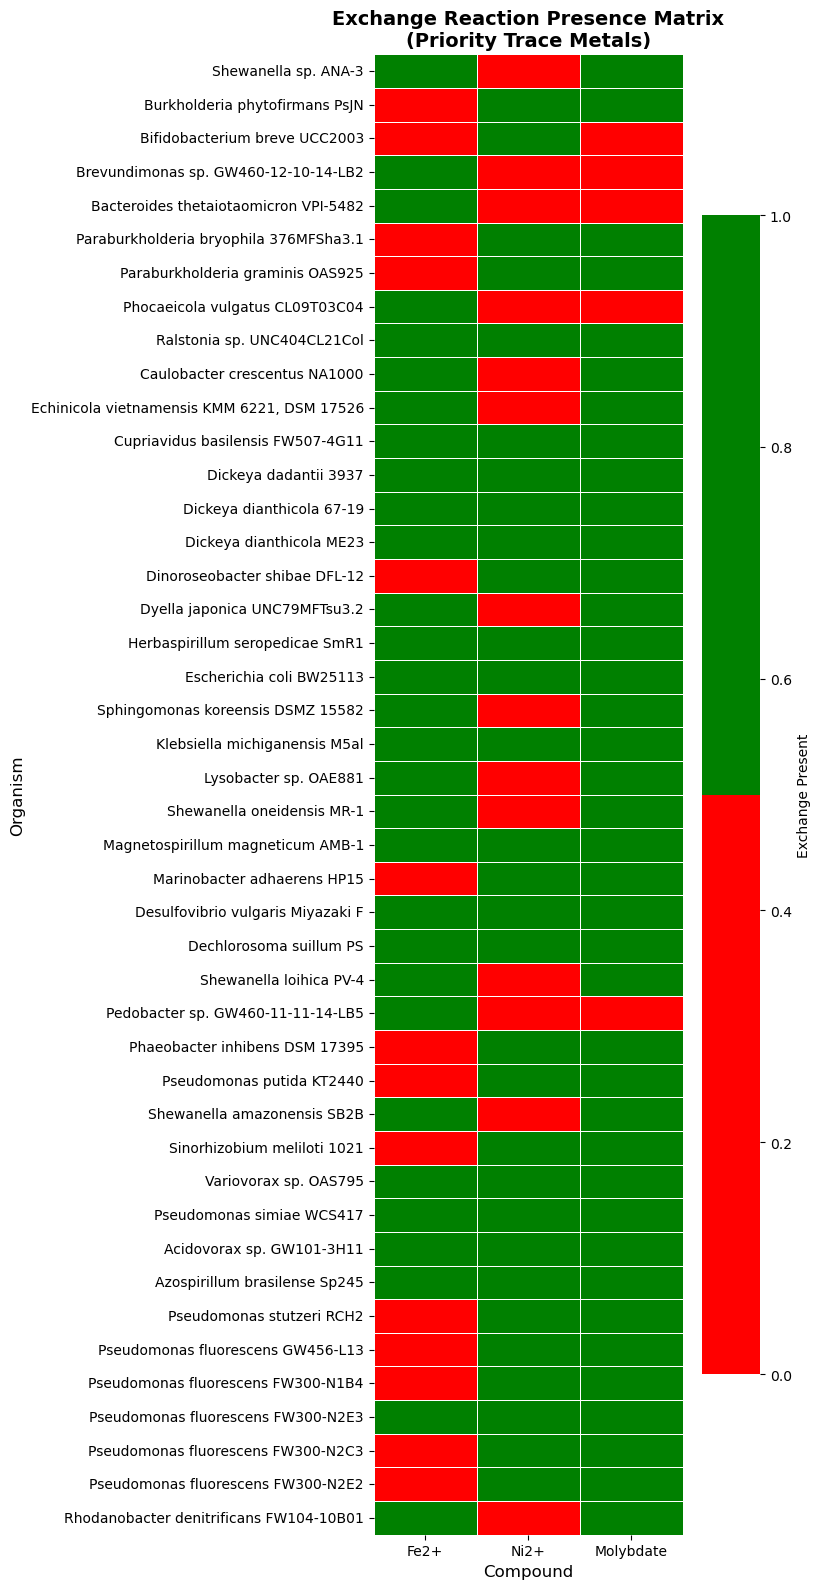

Saved: results/exchange_presence_heatmap.png


In [39]:
# Heatmap: Exchange presence matrix for priority compounds
fig, ax = plt.subplots(figsize=(8, 16))

# Create matrix for heatmap
heatmap_data = exchange_df.set_index('organism')[priority_compounds].astype(int)
heatmap_data.columns = [essential_compounds[cpd] for cpd in priority_compounds]

sns.heatmap(
    heatmap_data,
    cmap=['red', 'green'],
    cbar_kws={'label': 'Exchange Present'},
    linewidths=0.5,
    ax=ax
)

ax.set_title('Exchange Reaction Presence Matrix\n(Priority Trace Metals)', fontsize=14, fontweight='bold')
ax.set_xlabel('Compound', fontsize=12)
ax.set_ylabel('Organism', fontsize=12)

plt.tight_layout()
plt.savefig('results/exchange_presence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/exchange_presence_heatmap.png")

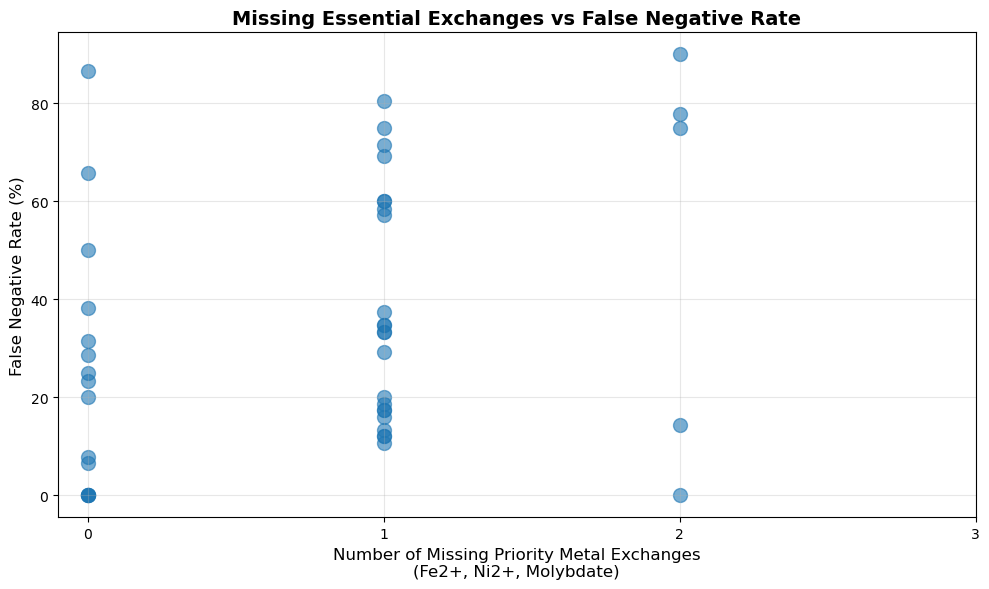

Saved: results/missing_exchanges_vs_fn_rate.png


In [40]:
# Scatter plot: Missing exchanges vs FN rate
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate total missing priority compounds
exchange_performance['missing_priority_metals'] = (
    (~exchange_performance['cpd10515']).astype(int) +
    (~exchange_performance['cpd00244']).astype(int) +
    (~exchange_performance['cpd11574']).astype(int)
)

ax.scatter(
    exchange_performance['missing_priority_metals'],
    exchange_performance['FN_rate'] * 100,
    alpha=0.6,
    s=100
)

ax.set_xlabel('Number of Missing Priority Metal Exchanges\n(Fe2+, Ni2+, Molybdate)', fontsize=12)
ax.set_ylabel('False Negative Rate (%)', fontsize=12)
ax.set_title('Missing Essential Exchanges vs False Negative Rate', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks([0, 1, 2, 3])

plt.tight_layout()
plt.savefig('results/missing_exchanges_vs_fn_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/missing_exchanges_vs_fn_rate.png")

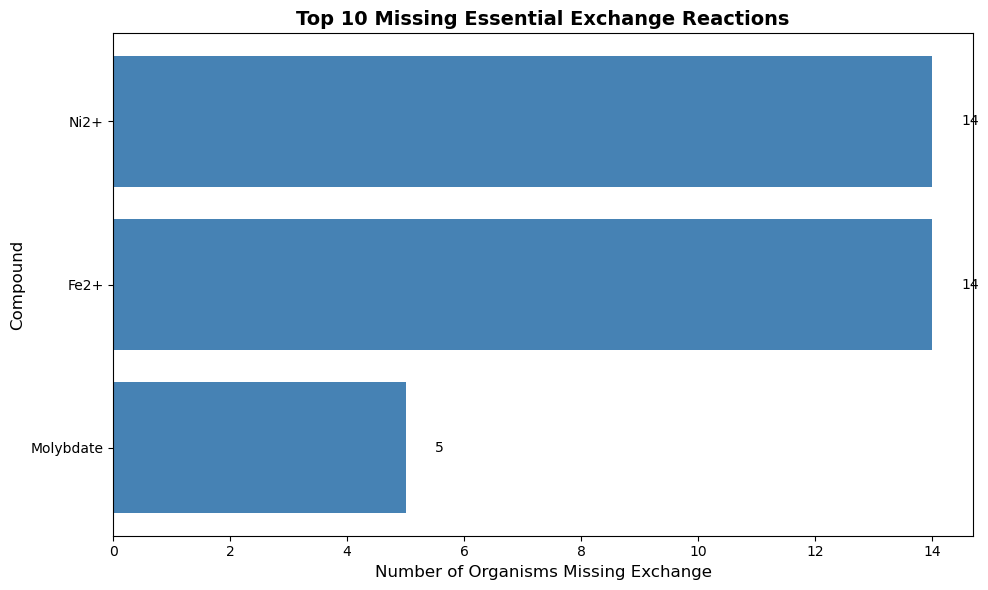

Saved: results/missing_exchanges_by_compound.png


In [41]:
# Bar plot: Missing exchanges by compound
fig, ax = plt.subplots(figsize=(10, 6))

missing_counts = missing_by_compound.head(10)

ax.barh(missing_counts['compound_name'], missing_counts['count'], color='steelblue')
ax.set_xlabel('Number of Organisms Missing Exchange', fontsize=12)
ax.set_ylabel('Compound', fontsize=12)
ax.set_title('Top 10 Missing Essential Exchange Reactions', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add count labels
for i, (idx, row) in enumerate(missing_counts.iterrows()):
    ax.text(row['count'] + 0.5, i, str(row['count']), va='center', fontsize=10)

plt.tight_layout()
plt.savefig('results/missing_exchanges_by_compound.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/missing_exchanges_by_compound.png")

## 7. Save Results

In [42]:
# Save exchange presence matrix
exchange_df.to_csv('results/exchange_reaction_matrix.csv', index=False)
print("Saved: results/exchange_reaction_matrix.csv")

# Save missing exchanges details
missing_exchanges_df.to_csv('results/missing_exchanges_details.csv', index=False)
print("Saved: results/missing_exchanges_details.csv")

# Save draft vs gap-filled comparison
draft_vs_gapfilled_df.to_csv('results/draft_vs_gapfilled_exchange_comparison.csv', index=False)
print("Saved: results/draft_vs_gapfilled_exchange_comparison.csv")

# Save model statistics
model_stats_df.to_csv('results/model_statistics.csv', index=False)
print("Saved: results/model_statistics.csv")

# Save exchange performance correlation
exchange_performance.to_csv('results/exchange_performance_correlation.csv', index=False)
print("Saved: results/exchange_performance_correlation.csv")

Saved: results/exchange_reaction_matrix.csv
Saved: results/missing_exchanges_details.csv
Saved: results/draft_vs_gapfilled_exchange_comparison.csv
Saved: results/model_statistics.csv
Saved: results/exchange_performance_correlation.csv


## 8. Summary Report

In [43]:
print("="*80)
print("EXCHANGE REACTION GAP ANALYSIS - SUMMARY REPORT")
print("="*80)
print()

print(f"Total organisms analyzed: {len(exchange_df)}")
print(f"Total essential compounds checked: {len(essential_compounds)}")
print(f"Total missing exchanges identified: {len(missing_exchanges_df)}")
print()

print("PRIORITY TRACE METALS (High FN Correlation):")
print("-" * 80)
for cpd_id in priority_compounds:
    cpd_name = essential_compounds[cpd_id]
    missing_count = (~exchange_df[cpd_id]).sum()
    pct_missing = (missing_count / len(exchange_df)) * 100
    print(f"{cpd_name} ({cpd_id}): {missing_count} organisms missing ({pct_missing:.1f}%)")
print()

print("GAP-FILLING BEHAVIOR:")
print("-" * 80)
for cpd_id in priority_compounds:
    cpd_data = draft_vs_gapfilled_df[draft_vs_gapfilled_df['compound_id'] == cpd_id]
    cpd_name = essential_compounds[cpd_id]
    print(f"{cpd_name}:")
    print(f"  - Missing in both draft and gap-filled: {cpd_data['missing_in_both'].sum()}")
    print(f"  - Added by gap-filling: {cpd_data['added_by_gapfilling'].sum()}")
    print(f"  - Already in draft: {cpd_data['in_draft'].sum()}")
print()

print("CORRELATION WITH FALSE NEGATIVES:")
print("-" * 80)
for cpd_id in priority_compounds:
    cpd_name = essential_compounds[cpd_id]
    has_exchange = exchange_performance[exchange_performance[cpd_id] == True]
    missing_exchange = exchange_performance[exchange_performance[cpd_id] == False]
    
    if len(missing_exchange) > 0:
        avg_fn_has = has_exchange['FN_rate'].mean() if len(has_exchange) > 0 else 0
        avg_fn_missing = missing_exchange['FN_rate'].mean()
        diff = avg_fn_missing - avg_fn_has
        
        print(f"{cpd_name}: FN rate {avg_fn_missing:.1%} (missing) vs {avg_fn_has:.1%} (present)")
        print(f"  Difference: {diff:.1%}")
print()

print("KEY FINDINGS:")
print("-" * 80)
print("1. Essential trace metal exchanges are missing in gap-filled models")
print("2. Missing exchanges strongly correlate with False Negative rates")
print("3. Gap-filling did NOT add these exchanges even though compounds were in media")
print("4. Most missing exchanges were absent in both draft and gap-filled models")
print()

print("RECOMMENDATION:")
print("-" * 80)
print("Proceed to Notebook 4 to add missing essential exchanges to models")
print("and re-run FBA simulations to validate improvement.")
print("="*80)

EXCHANGE REACTION GAP ANALYSIS - SUMMARY REPORT

Total organisms analyzed: 44
Total essential compounds checked: 19
Total missing exchanges identified: 33

PRIORITY TRACE METALS (High FN Correlation):
--------------------------------------------------------------------------------
Fe2+ (cpd10515): 14 organisms missing (31.8%)
Ni2+ (cpd00244): 14 organisms missing (31.8%)
Molybdate (cpd11574): 5 organisms missing (11.4%)

GAP-FILLING BEHAVIOR:
--------------------------------------------------------------------------------
Fe2+:
  - Missing in both draft and gap-filled: 14
  - Added by gap-filling: 0
  - Already in draft: 30
Ni2+:
  - Missing in both draft and gap-filled: 14
  - Added by gap-filling: 0
  - Already in draft: 30
Molybdate:
  - Missing in both draft and gap-filled: 5
  - Added by gap-filling: 0
  - Already in draft: 39

CORRELATION WITH FALSE NEGATIVES:
--------------------------------------------------------------------------------
Fe2+: FN rate 42.9% (missing) vs 30.4% (